In [1]:
import config
import numpy as np 
import matplotlib.pyplot as plt
from aml import graph_layout
import torch
from sklearn import decomposition
from sklearn import manifold
from Alg.solving_algorithm import ModelGenerator
from CustomModels.my_models import Integrator
import os
from Losses.Losses import *
from tqdm import tqdm
from aml.plotting import *
from matplotlib import cm
import matplotlib
from scipy.spatial import ConvexHull

In [2]:
N = 1000 
adj_m =  torch.load(config.Phi_adj_matrix)
all_distances = np.zeros(shape=(int(N*(N-1)/2),))
k_ = 0
for i in range(1,N-1):
    for j in range(i,N):
        all_distances[k_] = adj_m[i][j]
        k_ +=1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.35630418086082


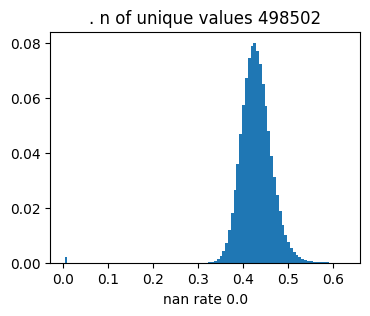

In [4]:
plot_float_distribution(all_distances)
print(np.sort(all_distances)[:100])
print(np.percentile(all_distances,1))

using device cpu


100%|██████████| 550/550 [01:27<00:00,  6.27it/s]


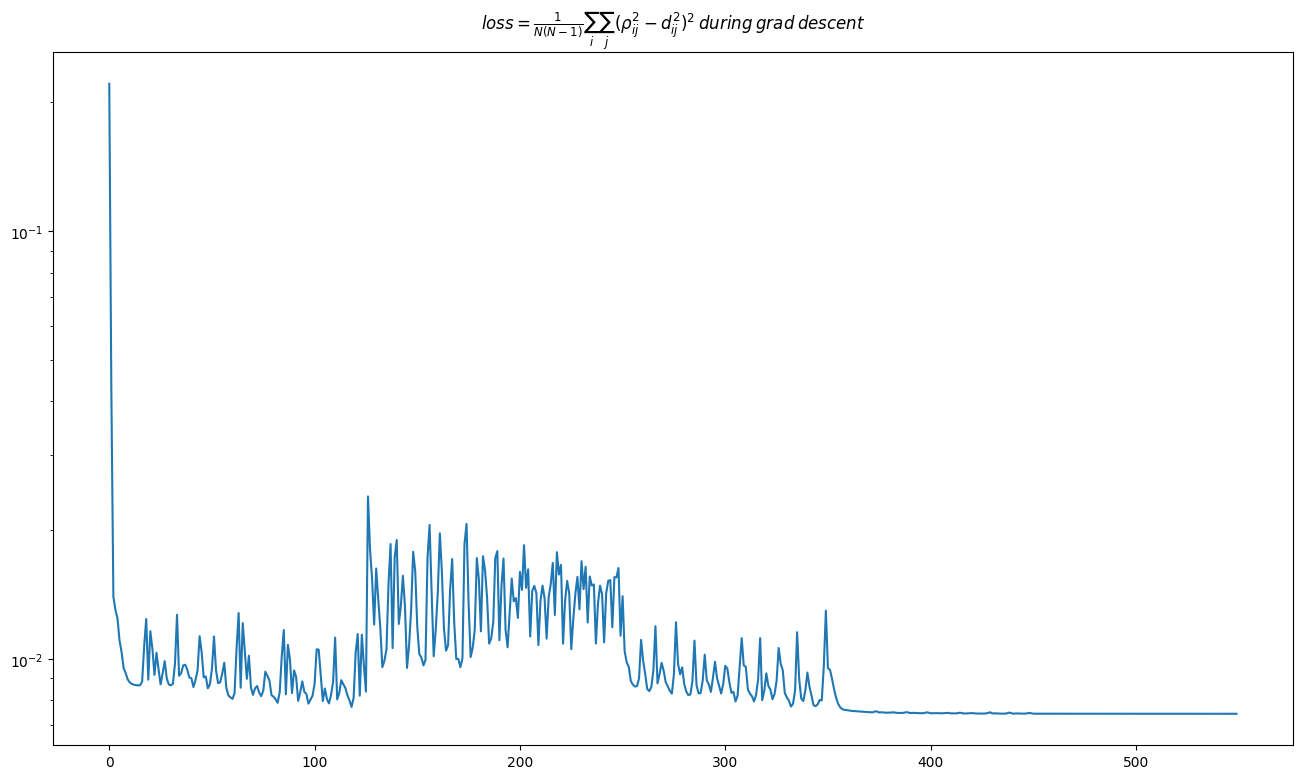

In [59]:
gr_model = graph_layout.GraphOnAPlane(adj_m,size_of_output_space = 3)
gr_model.fit()
gr_model.plot_loss()
positions = gr_model.get_pos()

In [60]:
print(positions.shape)
torch.save(positions, config.Phi_vector_representation)

(1000, 3)


In [5]:
colors_ = ['b' for i in range(len(positions))]
unique_labels_colors_ = ['b']
unique_labels_ = [0]

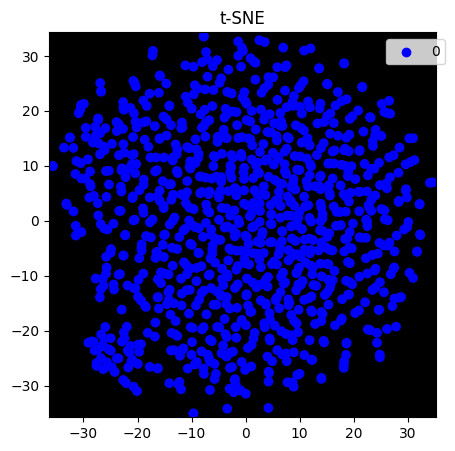

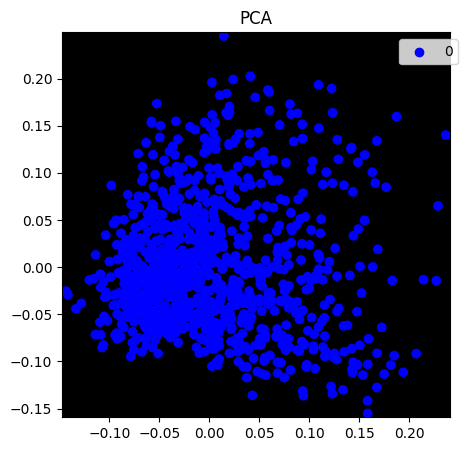

In [6]:
dim_reduction_alg1 = manifold.TSNE(n_components=2)
dim_reduction_alg2 = decomposition.PCA(n_components=2)
positions_1 = dim_reduction_alg1.fit_transform(positions)
positions_2 = dim_reduction_alg2.fit_transform(positions)
N_ = len(positions)
fig,ax1 = graph_layout.cluster_plot((5,5), positions_1, colors_of_points=colors_,color_for_labels=unique_labels_colors_,labels_for_colors=unique_labels_)
fig,ax2 = graph_layout.cluster_plot((5,5), positions_2, colors_of_points=colors_,color_for_labels=unique_labels_colors_,labels_for_colors=unique_labels_)
ax1.set_title('t-SNE')
ax2.set_title('PCA')
plt.show()

compute quality criterion of p

In [3]:
mg = ModelGenerator(rules=config.rules,
                            cache_dir=config.Phi_cache_dir,
                            clear_cache=False)
all_p = [torch.load(os.path.join(mg.cache_dir, 'distrib4D_{}.txt'.format(i))) for i in range(N)]

In [4]:
shared_integration_supports = Integrator(dir_=config.integrator_dir,
                                        shared_data=mg.shared_data,
                                        clear_cache=True).shared_integration_supports


     num_of_rect_in_intersection 17090


In [5]:
L = np.zeros(shape=(N,))
for i in tqdm(range(N)):
    p_ = all_p[i]
    L_i = get_L2_Distrib4D(p_, shared_integration_supports)
    L[i] = L_i

100%|██████████| 1000/1000 [11:38<00:00,  1.43it/s]


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': '. n of unique values 1000'}, xlabel='nan rate 0.0'>)

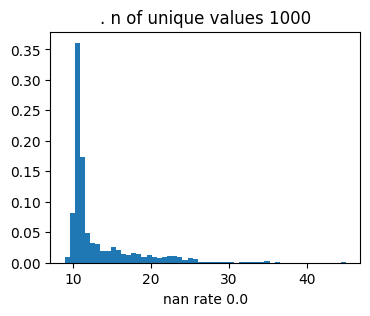

In [6]:
plot_float_distribution(L)

In [12]:
torch.save(L, os.path.join(config.task_dir, 'L2_for_Phi.txt'))

In [61]:
positions = torch.load(config.Phi_vector_representation)
print(positions.shape)

(1000, 3)


In [62]:
L = torch.load(os.path.join(config.task_dir, 'L2_for_Phi.txt'))

In [63]:
dim_reduction_alg1 = manifold.TSNE(n_components=2)
dim_reduction_alg2 = decomposition.PCA(n_components=2)
# dim_reduction_alg2 = decomposition.TruncatedSVD(n_components=2)
positions_1 = dim_reduction_alg1.fit_transform(positions)
positions_2 = dim_reduction_alg2.fit_transform(positions)
print(positions_1.shape)

(1000, 2)


8.576887336570412 44.75616633687086


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': '. n of unique values 1000'}, xlabel='nan rate 0.0'>)

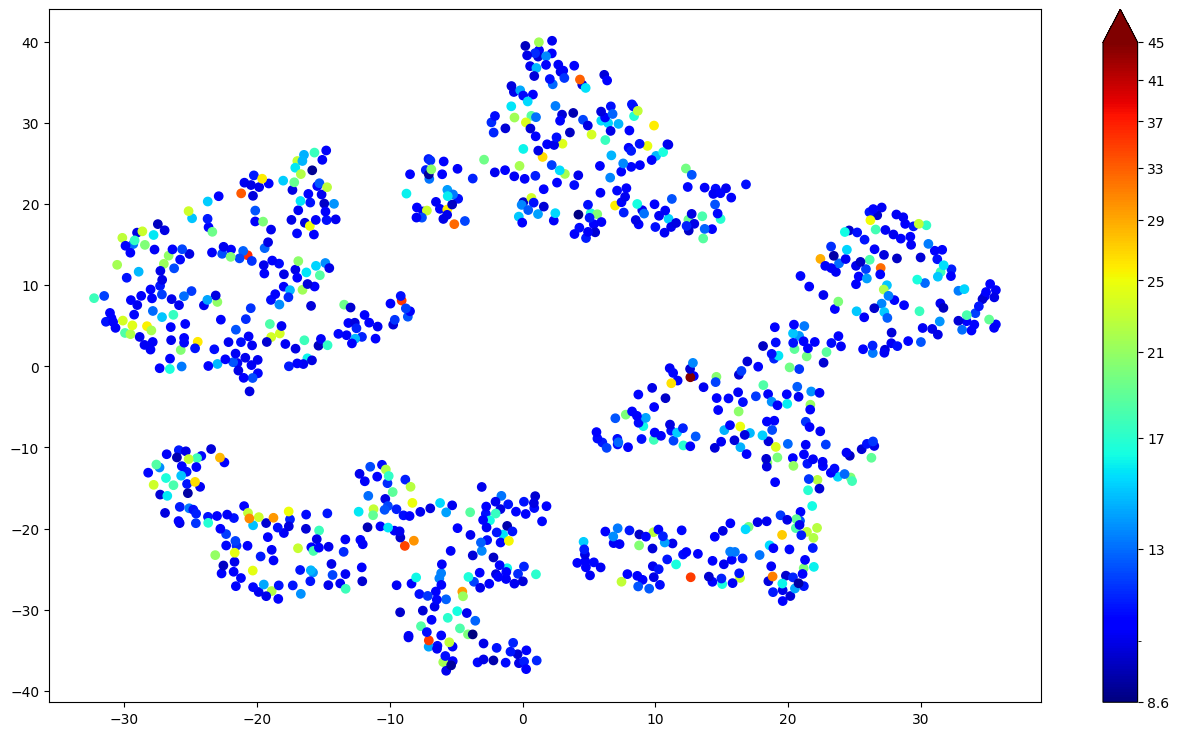

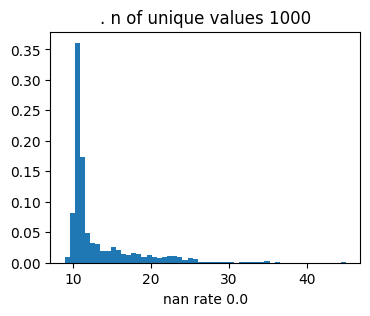

In [64]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return '$'+r"{0} \times 10^{{{1}}}".format(base, int(exponent))+'$'
    else:
        return float_str
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
# L_sorted = np.sort(L-np.min(L))
# L_ = L-np.min(L)+L_sorted[1]
# print(L_sorted[1])
L_ = L
# L_ = L
# L_ = np.log(L_)
# norm = matplotlib.colors.Normalize(vmin=min(L_), vmax=max(L_))
# norm = matplotlib.colors.LogNorm(vmin=min(L_), vmax=max(L_))
norm = matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=min(L_), vmax=max(L_), base=10)
m = cm.ScalarMappable(norm=norm, cmap=cm.jet)
ax.scatter(x = [positions_1[i][0] for i in range(N)],y= [positions_1[i][1] for i in range(N)],c=[m.to_rgba(L_ [i]) for i in range(N)])
cbar = fig.colorbar(m, ax=ax,extend='max',ticks= np.linspace(np.min(L_),np.max(L_),10))
cbar.ax.set_yticklabels([latex_float(i) for i in np.linspace(np.min(L_),np.max(L_),10)])
print(min(L_),max(L_))
plot_float_distribution(L_)

8.576887336570412 44.75616633687086


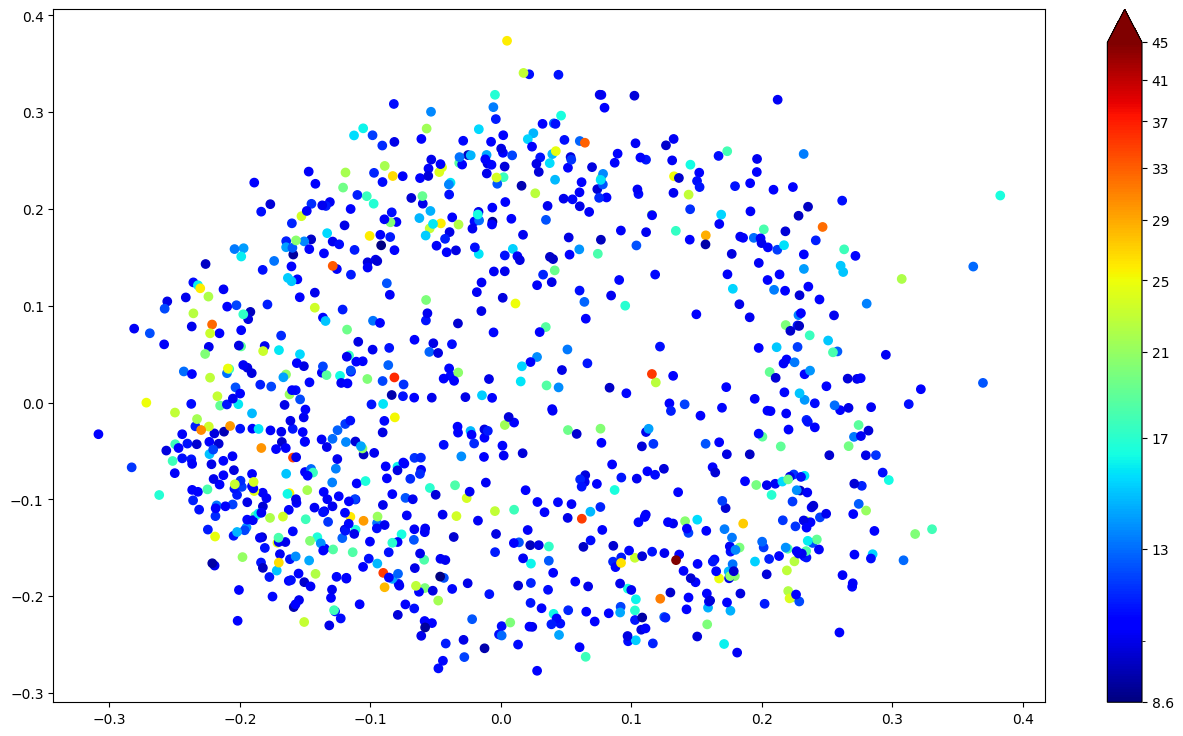

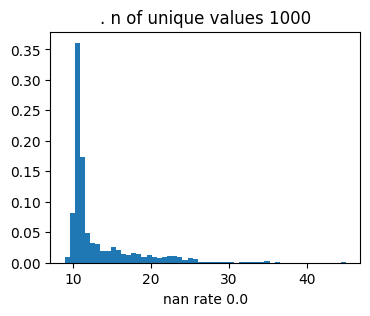

In [65]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return '$'+r"{0} \times 10^{{{1}}}".format(base, int(exponent))+'$'
    else:
        return float_str
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
# L_sorted = np.sort(L-np.min(L))
# L_ = L-np.min(L)+L_sorted[1]
# print(L_sorted[1])
L_ = L
# L_ = L
# L_ = np.log(L_)
# norm = matplotlib.colors.Normalize(vmin=min(L_), vmax=max(L_))
# norm = matplotlib.colors.LogNorm(vmin=min(L_), vmax=max(L_))
norm = matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=min(L_), vmax=max(L_), base=10)
m = cm.ScalarMappable(norm=norm, cmap=cm.jet)
ax.scatter(x = [positions_2[i][0] for i in range(N)],y= [positions_2[i][1] for i in range(N)],c=[m.to_rgba(L_ [i]) for i in range(N)])
cbar = fig.colorbar(m, ax=ax,extend='max',ticks= np.linspace(np.min(L_),np.max(L_),10))
cbar.ax.set_yticklabels([latex_float(i) for i in np.linspace(np.min(L_),np.max(L_),10)])
print(min(L_),max(L_))
plot_float_distribution(L_)
fig.savefig('./surf_of_Loss.png')

save points for latex plot

In [66]:
print(positions_2.shape)

(1000, 2)


In [67]:
hull = ConvexHull(positions_2)

In [68]:
print(len(np.array(hull.simplices,dtype=np.intc).flatten()))

28


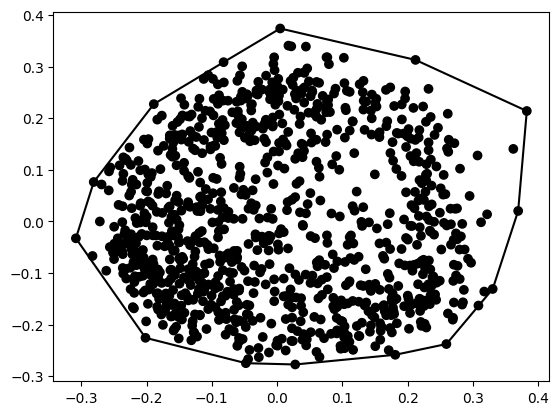

In [69]:
fig3,ax3 = plt.subplots()
for simplex in hull.simplices:
    points = positions_2[simplex]
    x_j = [el[0] for el in points]
    y_j = [el[1] for el in points]
    ax3.plot(x_j,y_j,c='k')
ax3.scatter(x = [positions_2[i][0] for i in range(N)],y= [positions_2[i][1] for i in range(N)],
            color=[(0,0,0) for i in range(N)])
fig3.savefig('./Conv.png')

In [70]:
hull_big = ConvexHull(positions)

In [71]:
print(len(hull_big.simplices))

156


In [72]:
all_vertexes=[]
for simplex in hull_big.simplices:
    for j in range(len(simplex)):
        all_vertexes.append(simplex[j])

In [73]:
support_vertexes = np.unique(all_vertexes)
print(support_vertexes)
print(len(support_vertexes))

[  0   4  49  77 108 115 120 130 143 161 181 218 219 281 290 309 314 316
 329 336 343 349 353 361 363 386 389 409 426 432 443 457 463 497 499 529
 534 547 563 578 600 605 606 608 621 623 644 647 655 687 721 730 731 733
 762 803 815 834 837 868 877 878 881 893 896 904 913 926 947 959 960 961
 964 968 973 980 985 990 992 993]
80


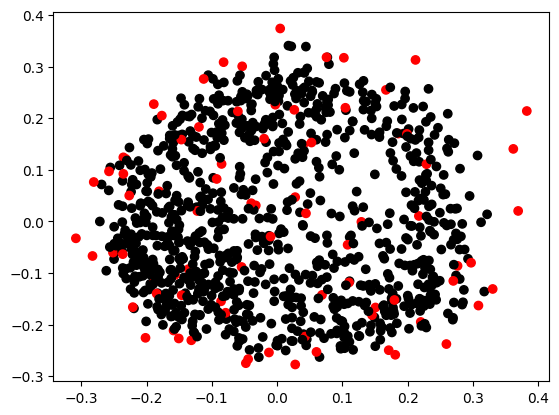

In [75]:
fig4,ax4 = plt.subplots()
support_vertexes_x = [positions_2[el][0] for el in support_vertexes]
support_vertexes_y = [positions_2[el][1] for el in support_vertexes]
colors = []
for i in range(N):
    if i in support_vertexes:
        colors.append((1,0,0))
    else:
        colors.append((0,0,0))
ax4.scatter(x = [positions_2[i][0] for i in range(N)],y= [positions_2[i][1] for i in range(N)],
            color=colors)

In [76]:
torch.save(support_vertexes, os.path.join(config.task_dir, 'support_points.txt'))